# Importações

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
import warnings
warnings.filterwarnings("ignore")

c:\Users\talmeidar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\talmeidar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Não Supervisionado

# Lendo dataset

In [2]:
# Carregar o conjunto de dados
data = pd.read_csv('../../Datasets/Mall_Customers.csv',index_col='CustomerID')
data

,Genre,Age,Annual_Income_(k$),Spending_Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Genre               200 non-null    object
 1   Age                 200 non-null    int64 
 2   Annual_Income_(k$)  200 non-null    int64 
 3   Spending_Score      200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [4]:
# Checagem de nulos
data.isna().sum()

Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

In [5]:
# Checagem de dados duplicados
data.duplicated().sum()

0

Aqui damos uma olhada no dataset para ver como os dados estão

In [6]:
data.describe()

,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


# KMeans

## Função que executa o kmeans em um dataset X calculando k medias

In [7]:
def calculateKMeans(dataset, n_clusters):
    """
    Calcula o modelo K-Means para um conjunto de dados.

    Parâmetros:
    dataset (array-like): Conjunto de dados a ser agrupado.
    n_clusters (int): Número de clusters a serem formados pelo algoritmo K-Means.

    Retorna:
    KMeans: O modelo K-Means treinado.
    """
    # Cria o modelo K-Means com o número especificado de clusters e uma semente de aleatoriedade fixa
    model = KMeans(n_clusters=n_clusters, random_state=15)
    
    # Ajusta o modelo aos dados fornecidos
    model.fit(dataset)
    
    # Retorna o modelo K-Means treinado
    return model

# Calculando quantidade de clusters

- Inicialmente a quantidade de clusters é limitada a raiz quadrada do número de amostras dividido por 2.
- Depois calculamos a quantidade de clusters ideal usando o método do cotovelo
- Depois calculamos a quantidade ideal de clusters usando o método da silhueta numérico e visual

In [8]:
limit = int((data.shape[0]//2)**0.5)
limit

10

## Cotovelo

Com o método do cotovelo avaliamos no gráfico onde a melhora nos níveis de variação começa a cair mais devagar.
Como o KMeans calcula a distância das observações até o centro do agrupamento que ela pertence, o ideal é que essa distância seja a menor viável. Matematicamente falando, nós estamos buscando uma quantidade de agrupamentos em que a soma dos quadrados intra-clusters (do inglês, within-clusters sum-of-squares (wcss)) seja a menor possível, sendo zero o resultado ótimo.

In [20]:
# Selecionar só 2 colunas para visualização
selected_columns = ['Annual_Income_(k$)', 'Spending_Score']
df = data[selected_columns]

wcss = []
for i in range(2, 11):
    kmeans = calculateKMeans(df,i)
    # método inércia, retorna o wcss do modelo
    wcss.append(kmeans.inertia_)

In [21]:
wcss

[181363.59595959596,
 106348.37306211119,
 73679.78903948834,
 44454.47647967974,
 37271.88623658949,
 33662.49190020505,
 25062.433792653785,
 22882.625101647514,
 21232.540729353143]

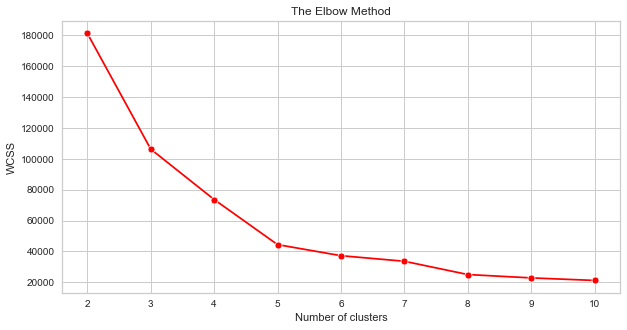

In [22]:
plt.figure(figsize=(10,5))
sns.lineplot(range(2, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
model =  KMeans(init = 'k-means++', random_state=15)
visualizer = KElbowVisualizer(model, k=(2,limit))

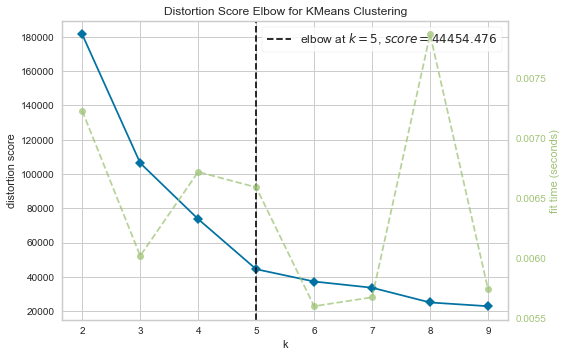

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
visualizer.fit(df)
visualizer.show()

## Silhueta

Método de silhueta observando a média dos valores de silhueta, quanto maior a média dos valores de silhueta, melhor a distribuição

In [25]:
for k in range(2, limit+1):
    """
    Itera sobre uma faixa de valores de k (número de clusters) para calcular e exibir o Silhouette Score para cada valor de k.
    """
    # Calcula o modelo K-Means para o número atual de clusters k
    model = calculateKMeans(df, k)
    
    # Faz previsões de cluster para o conjunto de dados
    pred = model.predict(df)
    
    # Calcula o Silhouette Score para as previsões de cluster
    score = silhouette_score(df, pred)
    
    # Exibe o Silhouette Score para o número atual de clusters k
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

Silhouette Score for k = 2: 0.297
Silhouette Score for k = 3: 0.468
Silhouette Score for k = 4: 0.493
Silhouette Score for k = 5: 0.553
Silhouette Score for k = 6: 0.538
Silhouette Score for k = 7: 0.502
Silhouette Score for k = 8: 0.453
Silhouette Score for k = 9: 0.449
Silhouette Score for k = 10: 0.430


Método de silhueta observando todos os valores graficamente

Para observar graficamente olhamos o tamanho de cada cluster, considerando se estão com quantidades uniformes ou não, se os clusters possuem scores acima da média(linha tracejada vermelha ou não) e como está a distribuição dos valores (valores mais positivos são melhores )

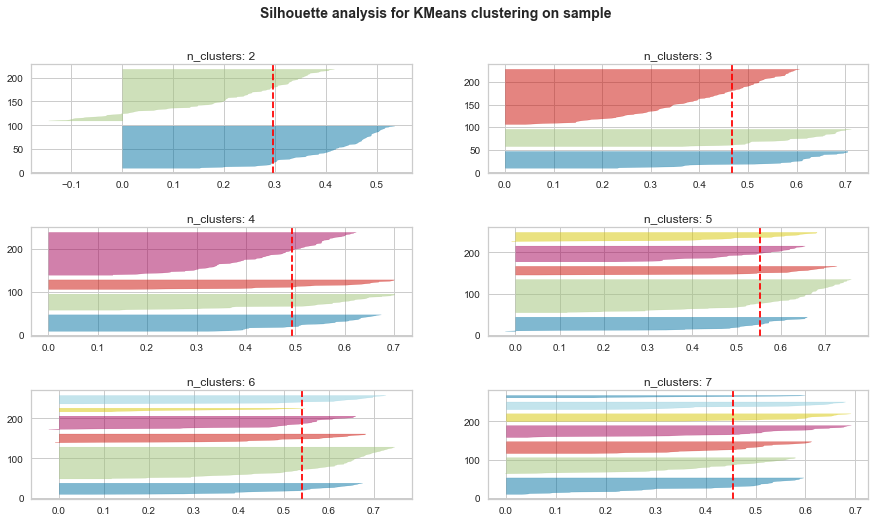

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
count = 2

# Define os títulos dos subplots com base no número de clusters
for axes in ax:
    for axe in axes:
        axe.set_title(f"n_clusters: {count}")
        count += 1

# Itera sobre diferentes números de clusters para análise de Silhouette
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Cria a instância KMeans para diferentes números de clusters
    '''
    km = calculateKMeans(df, i)
    q, mod = divmod(i, 2) # Divisão e resto para plotagem dos gráficos em subplots 3x2
    
    '''
    Cria a instância SilhouetteVisualizer com a instância KMeans e dá um fit no visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)
    
    # Define o título principal do gráfico
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample",
        fontsize=14,
        fontweight="bold",
    )

Com a silhueta e cotovelo podemos ver que o número de clusters ideal para esse problema é 5, visto que os clusters possuem tamanhos mais uniformes, valores acima da média e não possuem muitos valores negativos.

In [26]:
kmeans = calculateKMeans(df,5)

In [27]:
predictions = kmeans.predict(df)

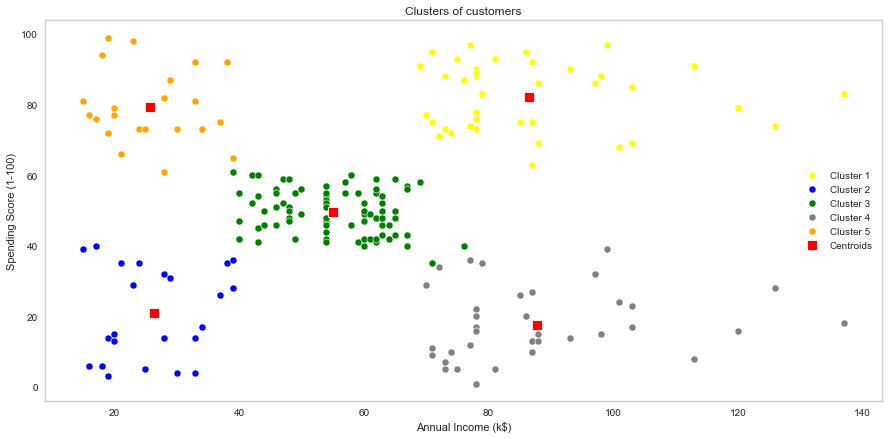

In [28]:
# Visualização dos grupos
plt.figure(figsize=(15,7))

# Plota os pontos do Cluster 1
sns.scatterplot(df[predictions == 0]['Annual_Income_(k$)'].values, 
                df[predictions == 0]['Spending_Score'].values, 
                color='yellow', label='Cluster 1', s=50)

# Plota os pontos do Cluster 2
sns.scatterplot(df[predictions == 1]['Annual_Income_(k$)'].values, 
                df[predictions == 1]['Spending_Score'].values, 
                color='blue', label='Cluster 2', s=50)

# Plota os pontos do Cluster 3
sns.scatterplot(df[predictions == 2]['Annual_Income_(k$)'].values, 
                df[predictions == 2]['Spending_Score'].values, 
                color='green', label='Cluster 3', s=50)

# Plota os pontos do Cluster 4
sns.scatterplot(df[predictions == 3]['Annual_Income_(k$)'].values, 
                df[predictions == 3]['Spending_Score'].values, 
                color='grey', label='Cluster 4', s=50)

# Plota os pontos do Cluster 5
sns.scatterplot(df[predictions == 4]['Annual_Income_(k$)'].values, 
                df[predictions == 4]['Spending_Score'].values, 
                color='orange', label='Cluster 5', s=50)

# Plota os centróides dos clusters
sns.scatterplot(kmeans.cluster_centers_[:, 0], 
                kmeans.cluster_centers_[:, 1], 
                color='red', label='Centroids', s=100, marker=',')

# Desativa a grade do gráfico
plt.grid(False)

# Define o título do gráfico
plt.title('Clusters of customers')

# Define o rótulo do eixo X
plt.xlabel('Annual Income (k$)')

# Define o rótulo do eixo Y
plt.ylabel('Spending Score (1-100)')

# Adiciona a legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.show()

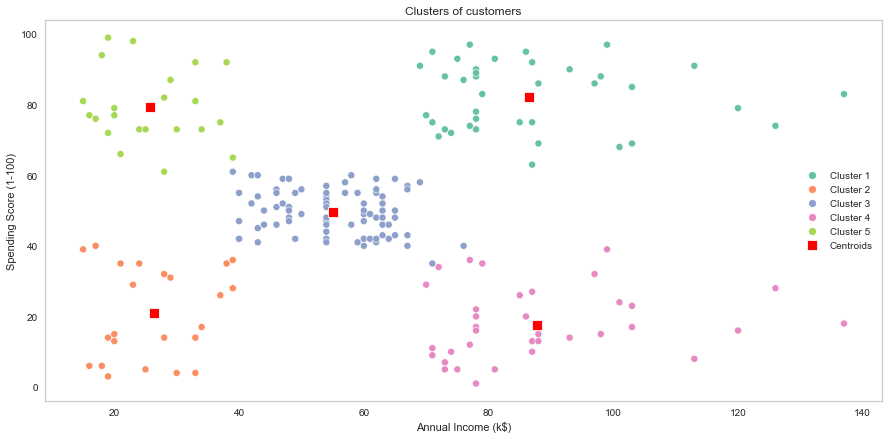

In [29]:
# Visualização dos grupos

# Define o tamanho da figura do gráfico
plt.figure(figsize=(15,7))

# Adiciona a coluna 'predictions' ao DataFrame com as previsões dos clusters
df['predictions'] = predictions

# Cria uma nova coluna 'label_predictions' com rótulos de clusters categorizados
df['label_predictions'] = pd.cut(df['predictions'], bins=5, labels=[f'Cluster {i}' for i in range(1, 6)])

# Plota os pontos dos clientes com cores diferentes para cada cluster
sns.scatterplot(df['Annual_Income_(k$)'].values, df['Spending_Score'].values, hue=df['label_predictions'].values, palette='Set2', s=50)

# Plota os centróides dos clusters
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', label='Centroids', s=100, marker=',')

# Desativa a grade do gráfico
plt.grid(False)

# Define o título do gráfico
plt.title('Clusters of customers')

# Define o rótulo do eixo X
plt.xlabel('Annual Income (k$)')

# Define o rótulo do eixo Y
plt.ylabel('Spending Score (1-100)')

# Adiciona a legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.show()